# Introduction

Object detection in the context of computer vision refers to a task where computers are prompted to identifying objects in images or videos. It is a very active research area, because its applications add a lot of value in different industry sectors. Identifying people in security cameras, identifying pedestrians, cars, and other vehicles in self driving cars are prominent applications of object detection. <br> <br>
The goal of this project is to implement three SOTA(State Of The Art) approaches that perform object detection videos. In order to do this, open source libraries and pre-trained models made available by researchers will be used.  An evaluation of the strengths and weaknesses of each approach will be performed. Benchmark results will be presented, and to simulate my own benchmark, I will run the same video sequence in the three models and compare the results.


## Enviroment setup

Detectron2 is an open source library published by Facebook AI Research team. It contains a "model zoo" for several common computer vision tasks, like object detection, image segmentation, facial keypoint detection, etc. I have used its python API to implement both Fast RCNN and RetinaNet.


Ultralytics is python library made available by the the company that holds the same name. This library include different implementations of the YOLO algorithms and a simple an intuitive API. For the analysis I will use Yolov8m, a medium size version of the model with 25.9 M parameters.


In [1]:
!pip install -q  'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip -q install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 12.5 MB/s eta 0:00:00


checking cuda version...

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
True


# Imports

In [4]:
from glob import glob
import detectron2
from detectron2.utils.logger import setup_logger
from tqdm.notebook import tqdm
setup_logger()
from IPython.display import Video, YouTubeVideo

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

import cv2
from google.colab.patches import cv2_imshow

 Next, I define a class containing the functionality to perform object detection and instance segmentation using detectron2, a computer vision framework made available by Facebook Research. This library contains several pre-trained models that can be used to benchmark results. Besides, its api is simple and quite straighforward to use.

In [5]:
class Detector:
    def __init__(self, model_path):
        self.cfg = get_cfg()
        # getting config for FASTER_RCNN with a ResNet + FPN backbone
        self.cfg.merge_from_file(model_zoo.get_config_file(model_path))
        # getting model weights
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_path)
        # setting the confidence threshold
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        self.cfg.MODEL.DEVICE = "cuda"
        self.predictor = DefaultPredictor(self.cfg)

    def onImage(self, imagePath, return_prediction=False):
        image = cv2.imread(imagePath)
        predictions = self.predictor(image)

        viz = Visualizer(image[:,:,::-1], metadata=MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]))
        # draw predictions and get output_image in RGB format
        image = viz.draw_instance_predictions(predictions['instances'].to('cpu')).get_image()[:,:,::-1]
        if return_prediction:
            return image
        else:
            cv2_imshow(image)
            cv2.waitKey(0)


### Playing with a test image...

[07/19 13:32:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


model_final_280758.pkl: 167MB [00:00, 176MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


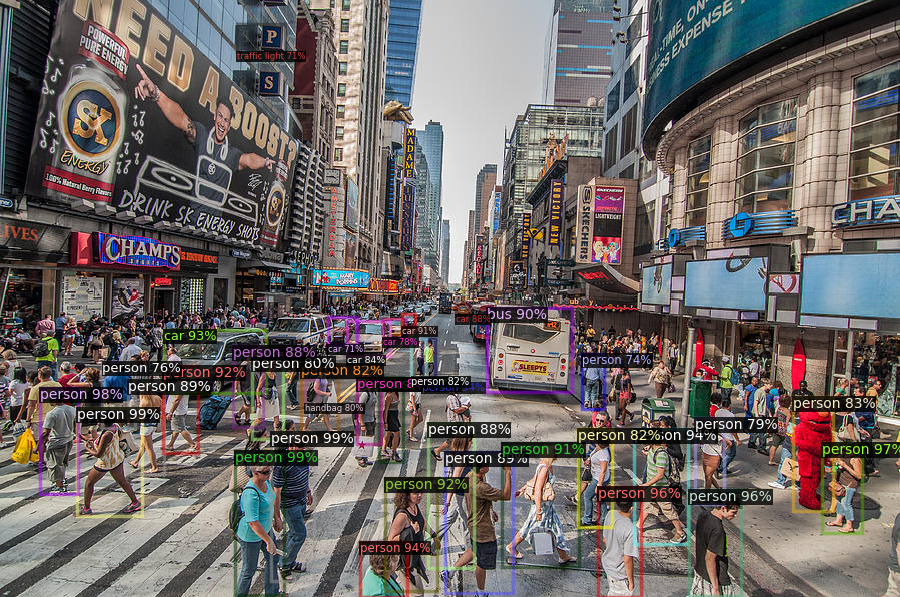

In [6]:
detector = Detector(model_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
detector.onImage("/content/testImage2.jpg")

### if we want to perform image segmentation, we can also use a pre-trained mask-rcnn with with ResNet50 + FPN backbone:

[07/19 13:32:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x/137260431/model_final_a54504.pkl ...


model_final_a54504.pkl: 178MB [00:01, 150MB/s]                           


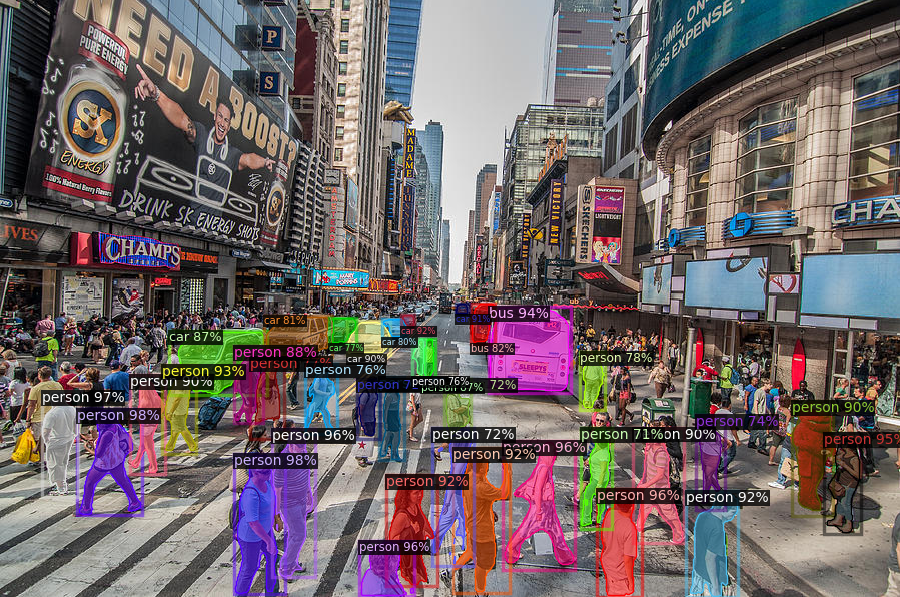

In [7]:
detector = Detector(model_path='COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml')
detector.onImage("/content/testImage2.jpg")

# Performing Object detection on benchmark video:

I have chosen video 4 from the training set of MOT16 dataset, because it contains a considerable number of people walking in the street. It will be interesting to observe whether the algorithms will be able to detect all objects in the video and how the distance to the camera will influence the detection. First, let's see the video original video:

In [8]:
from IPython.display import Video

Video('https://motchallenge.net/sequenceVideos/MOT16-04-raw.webm', height=540, width=960)

## loading benchmark dataset

I have downloaded the dataset from [MOT Challenge's official website](https://motchallenge.net/data/MOT16/) and uploaded it to my drive.<br>
I will now load it in the workspace, so I can run the model on MOT16-04 video sequence.

In [9]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/data
!unzip -d /content/data /content/drive/MyDrive/IU_computer_vision_project/dataset/MOT16.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/MOT16-02/img1/000329.jpg  
  inflating: /content/data/train/MOT16-02/img1/000330.jpg  
  inflating: /content/data/train/MOT16-02/img1/000331.jpg  
  inflating: /content/data/train/MOT16-02/img1/000332.jpg  
  inflating: /content/data/train/MOT16-02/img1/000333.jpg  
  inflating: /content/data/train/MOT16-02/img1/000334.jpg  
  inflating: /content/data/train/MOT16-02/img1/000335.jpg  
  inflating: /content/data/train/MOT16-02/img1/000336.jpg  
  inflating: /content/data/train/MOT16-02/img1/000337.jpg  
  inflating: /content/data/train/MOT16-02/img1/000338.jpg  
  inflating: /content/data/train/MOT16-02/img1/000339.jpg  
  inflating: /content/data/train/MOT16-02/img1/000340.jpg  
  inflating: /content/data/train/MOT16-02/img1/000341.jpg  
  inflating: /content/data/train/MOT16-02/img1/000342.jpg  
  inflating: /content/data/train/MOT16-02/img1/000343.jpg  
  inflating: /content/data/train/MOT16-02/img1/00

# Contender #1 - Faster RCNN with ResNet50 + FPN

This model was developed by researchers at Microsoft, and it is based on Convolutional Neural Networks. It introduced a Region Proposal Network(RPN) that generate region proposals that are then fed to the detention model. Each extracted feature vector is used to assign a region to either the background or a specific object class.  The architecture has three main components: the Region Proposal generator, the feature extraction, and classification module:

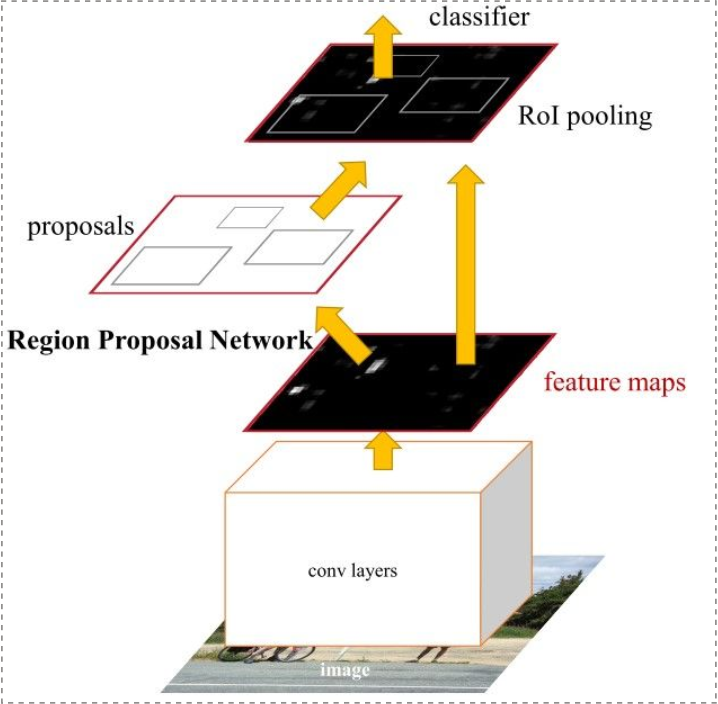

getting video frames...

In [10]:
frames = glob("/content/data/train/MOT16-04/img1/*")
# sort the frames based on image numbers
frames.sort(key = lambda x: int(x[-10:-4]))

In [11]:
frames[:10]

['/content/data/train/MOT16-04/img1/000001.jpg',
 '/content/data/train/MOT16-04/img1/000002.jpg',
 '/content/data/train/MOT16-04/img1/000003.jpg',
 '/content/data/train/MOT16-04/img1/000004.jpg',
 '/content/data/train/MOT16-04/img1/000005.jpg',
 '/content/data/train/MOT16-04/img1/000006.jpg',
 '/content/data/train/MOT16-04/img1/000007.jpg',
 '/content/data/train/MOT16-04/img1/000008.jpg',
 '/content/data/train/MOT16-04/img1/000009.jpg',
 '/content/data/train/MOT16-04/img1/000010.jpg']

loading object detection model...

In [12]:
detector = Detector(model_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

[07/19 13:33:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


Performing inference...

In [13]:
results = []
for imagePath in tqdm(frames):
    pred = detector.onImage(imagePath, return_prediction=True)
    results.append(pred)

  0%|          | 0/1050 [00:00<?, ?it/s]

converting frames back to video...

In [14]:
frameSize = (1920, 1080)
# create the writer
out = cv2.VideoWriter('MOT16-04_model1.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, frameSize)
for img in tqdm(results):
    out.write(img)
out.release()

  0%|          | 0/1050 [00:00<?, ?it/s]

I have downloaded the file: <br>
*MOT16-04_model1.avi*<br>
converted it to mp4, and uploaded it to my youtube channel. <br>
Click [this link](https://youtu.be/WQtb907DPkY) to see the result.


# Contender 2 - RetinaNet with Resnet50 + FPN as backbone

Retina Net is a one stage object detection model, whose main innovation was the use of a technique called "Focal loss", a dynamically scaled cross entropy loss function that allow the network to focus on classifying harder examples correctly.  Besides the backbone, it has two specific subnetworks: one for classifying the objects in the bounding-boxes, and other for estimating its coordinates(regression task).  Here is a high level overview: <br>

image.png

In [16]:
detector = Detector(model_path="COCO-Detection/retinanet_R_50_FPN_3x.yaml")

[07/19 13:41:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl ...


model_final_5bd44e.pkl: 152MB [00:03, 48.6MB/s]                           
  pixel_mean
  pixel_std


In [17]:
results = []
for imagePath in tqdm(frames):
    pred = detector.onImage(imagePath, return_prediction=True)
    results.append(pred)

  0%|          | 0/1050 [00:00<?, ?it/s]

In [18]:
frameSize = (1920, 1080)
# create the writer
out = cv2.VideoWriter('MOT16-04_model2.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, frameSize)
for img in tqdm(results):
    out.write(img)
out.release()

  0%|          | 0/1050 [00:00<?, ?it/s]

I have downloaded the file: <br>
*MOT16-04_model2.avi*<br>
Converted it to mp4, and uploaded it to my youtube channel.
[Click this link](https://youtu.be/-5o4pgAHjeQ) to see the result.

# Contender #3 YoloV8m

YOLO stands for "You Only Look Once" and, as the name suggests, it is a single shot detector. But while other algorightms like Faster RCNN and RetinaNet use auxiliary subnetworks to help identifying regions of interest, YOLO perform all of its predictions with the help of a single fully connected layer.  It divides the image into an SxS grid. Each grid cell will pass through the network, and it will output a vector that contains the probability that the cell contains an object, the object coordinates of the center, the predicted width and height of the object,  and the probabilities that the object belongs to a specific class. After this, a IOU(Intersection over Union) filter is applied to help distinguishing different objects from the same class(let's say a picture with two dogs). At last, a technique called Non Maximal Supression(NMS) is applied to select the final bounding box. Below is high level overview of the workflow: <br>

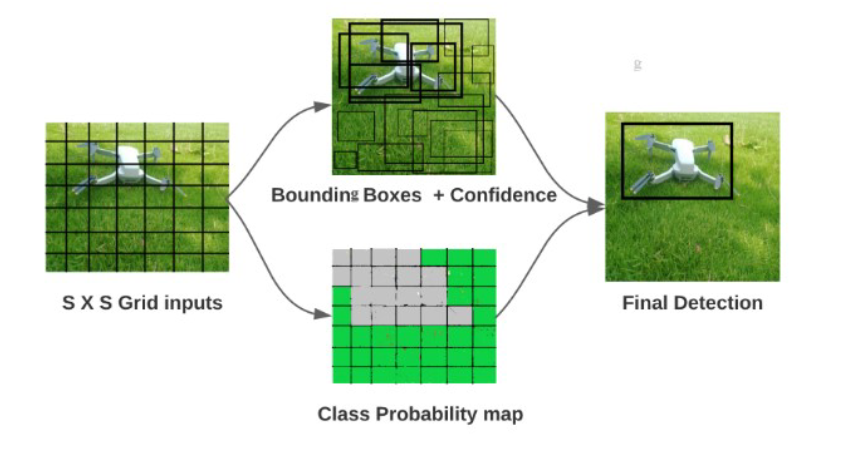
<br><br>
image.png

installing  necessary packages...

In [19]:
from ultralytics import YOLO

In [20]:
model = YOLO('yolov8m.pt')  # load official pre-trained model

100%|██████████| 49.7M/49.7M [00:00<00:00, 200MB/s]


In [21]:
%%time
results = model.predict('/content/data/train/MOT16-04/img1/', save=True)



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

image 1/1050 /content/data/train/MOT16-04/img1/000001.jpg: 384x640 10 persons, 60.3ms
image 2/1050 /content/data/train/MOT16-04/img1/000002.jpg: 384x640 11 persons, 8.2ms
image 3/1050 /content/data/train/MOT16-04/img1/000003.jpg: 384x640 13 persons, 7.8ms
image 4/1050 /content/data/train/MOT16-04/img1/000004.jpg: 384x640 11 persons, 7.6ms
image 5/1050 /content/data/train/MOT16-04/img1/000005.jpg: 384x640 10 persons, 7.8ms
image 6/1050 /content/data/train/

CPU times: user 1min 34s, sys: 5.31 s, total: 1min 39s
Wall time: 1min 40s


converting predicted image frames to video...

In [23]:
frames = glob('/content/runs/detect/predict/*')
frames.sort(key = lambda x: int(x[-10:-4]))
frameSize = (1920, 1080)
# create the writer
out = cv2.VideoWriter('MOT16-04_model3.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, frameSize)
for path in tqdm(frames):
    img = cv2.imread(path)
    out.write(img)
out.release()

  0%|          | 0/1050 [00:00<?, ?it/s]

I have downloaded the file: <br>
*MOT16-04_model3.avi*<br>
Converted it to mp4, and uploaded it to my youtube channel.Click [this link](https://youtu.be/OsNQzHe_YHQ) to see the result.

# Results discussion:
An in-depth discussion about the experiments results is located in the project report. After going through this notebook cells, please follow on there.<br>
<br>
Cheers,<br>
Hugo.

![to_be_continued.png](https://m.media-amazon.com/images/M/MV5BYjlkMGIwOTktZGNkYy00ZWIwLTk5MmYtMDQzNzBhMDM5MzEyXkEyXkFqcGdeQXVyNjc1NTYwNDk@._V1_.jpg)